# Projet 5 : Catégorisez automatiquement des questions
Étudiant BOUTROIX Laurent parcours Ingénieur Machine Learning

## Un Énoncé :
Amateur de Stack Overflow, qui vous a souvent sauvé la mise, vous décidez d'aider la communauté en retour. Pour cela, vous développez un système de suggestion de tag pour le site. Celui-ci prendra la forme d’un algorithme de machine learning qui assigne automatiquement plusieurs tags pertinents à une question.

## Des Contraintes :
Mettre en œuvre une approche non supervisée.
Utiliser une approche supervisée ou non pour extraire des tags à partir des résultats précédents.
Comparer ses résultats à une approche purement supervisée, après avoir appliqué des méthodes d’extraction de features spécifiques des données textuelles.
Mettre en place une méthode d’évaluation propre, avec une séparation du jeu de données pour l’évaluation.
Pour suivre les modifications du code final à déployer, utiliser un logiciel de gestion de versions, par exemple Git.

## Une Problématique :
Mettre en place un algorithme de machine learning qui assigne automatiquement plusieurs tags pertinents à une question.

## Hypothèse Générale :
Pouvons-nous mettre en place un algorithme de machine learning qui assigne automatiquement plusieurs tags pertinents à une question ?

## Hypothèses Secondaires :
Pouvons-nous mettre en place une méthode d’évaluation propre, avec une séparation du jeu de données pour l’évaluation ?

Pouvons-nous déployer le code final pour le mettre à la dispostion de la communauté ?


## Partie 2 : Tests des différents modèles.

### Installation des dépendances :

In [1]:
# pip install pyldavis

### Importation des dépendances :

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from math import ceil,sqrt,floor
from pprint import pprint

import random

import joblib

from ast import literal_eval

from PIL import Image
import dataframe_image as dfi

import datetime as dt
from datetime import date,timedelta
import time

#Preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

#LDA
from sklearn.decomposition import LatentDirichletAllocation as LDA

#Dimension reduction
from sklearn.decomposition import PCA
from sklearn import decomposition
import matplotlib.cm as cm

#pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

#gensim
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)


#Supervisée
from sklearn.datasets import make_multilabel_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import ClassifierChain

#models
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import Perceptron, LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB

#metrics
#from sklearn.metrics import metrics
import sklearn.metrics as metrics

#GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection
from sklearn.metrics import make_scorer

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings("ignore")

C:\Users\laure\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [3]:
random.seed(5)

In [4]:
start_dr1 = time.process_time()

### Importation de la base de données résultantes de la première partie :

In [5]:
df = pd.read_csv("./dfP05modelisation.csv", converters={"tag_tok": literal_eval, "question_lemtokcl": literal_eval})
df = df.drop(df.columns[[0]], axis=1)

### Définition des fonctions :

##### Définition d'une fonction `display_scree_plot()` qui trace l'éboulis des valeurs propres d'une réduction de dimension PCA.

In [6]:
def display_scree_plot(PcA):
    scree = PcA.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.axhline(y=95,color='green',linestyle='--', label = 'Inertie = 95%')
    plt.axhline(y=80,color='green',linestyle='--', label = 'Inertie = 80%')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.legend()
    plt.show(block=False)

##### Définition d'une fonction `print_topics()` qui affiche les topics déterminés par le modèle choisi.

In [7]:
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

##### Définition d'une fonction `metrics_model()` qui affiche dans un tableau différentes métriques d'un modèle de prédiction.

In [8]:
def metric_model(model_name, y_test, y_pred, time):   
    
    accuracy = metrics.accuracy_score(y_test, y_pred)
    score = metrics.f1_score(y_pred, y_test, average='weighted')
    jaccard = metrics.jaccard_score(y_test, y_pred, average='weighted')
    recall = metrics.recall_score(y_test, y_pred, average='weighted')
    precision = metrics.precision_score(y_test, y_pred, average='weighted')

    tab = pd.DataFrame({"Accuracy": [accuracy],"F1": [score],"Jaccard": [jaccard],"Recall": [recall],"Precision": [precision],"Run Time": [time]}, index=[model_name])
    tab.style.set_properties()
         
    return(tab)

### Inspection de df :

In [9]:
df

,Id,CreationDate,Tags,tag,tag_tok,question,question_lemtokcl,nb_w_title,nb_w_body,nb_w_quest,nb_tag,ViewCount,AnswerCount,Score
0,9,2008-07-31 23:40:59,<c#><.net><datetime>,csharp dotnet datetime,"[csharp, dotnet, datetime]",how do i calculate someone's age based on a da...,"[calculate, age, base, datetime, type, birthda...",12,15,27,3,716062,69,2081
1,59,2008-08-01 13:14:33,<c#><linq><.net-3.5>,csharp linq dotnet 3.5,"[csharp, linq, dotnet]","how do i get a distinct, ordered list of names...","[get, distinct, order, list, name, datatable, ...",15,47,62,4,26384,7,112
2,61,2008-08-01 13:17:20,<mime><file-type><office-2007>,mime file type office 2007,"[mime, file, type, office]","microsoft office 2007 file type, mime types an...","[microsoft, office, file, type, mime, type, id...",10,51,61,5,3892,1,50
3,126,2008-08-01 16:10:30,<java><php><oop><theory>,java php oop theory,"[java, php, oop, theory]",how would you access object properties from wi...,"[access, object, property, within, object, met...",11,200,211,4,19903,18,104
4,263,2008-08-01 23:27:24,<c><linux><gtk><x11>,c linux gtk xeleven,"[c, linux, gtk, xeleven]",gtk implementation of messagebox i have been t...,"[gtk, implementation, messagebox, try, impleme...",4,174,178,4,10547,3,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35804,70724561,2022-01-15 19:09:20,<python><numpy><matrix>,python numpy matrix,"[python, numpy, matrix]","in a matrix for a given index, how do i check ...","[matrix, give, index, check, neighboring, valu...",20,257,277,3,43,2,3
35805,70724782,2022-01-15 19:37:46,<javascript><html><css><image><next.js>,javascript html css image nextdotjs,"[javascript, html, css, image, nextdotjs]","if image is not wide enough, how to make it st...","[image, wide, enough, make, stretch, width, wi...",17,124,141,5,38,1,0
35806,70725005,2022-01-15 20:05:04,<c++><stringstream>,c++ stringstream,"[c++, stringstream]",declaring stringstream crashes the app in c++ ...,"[declare, stringstream, crash, app, c++, proje...",7,133,140,2,40,1,0
35807,70725976,2022-01-15 22:33:40,<java><generics>,java generics,"[java, generics]",how to make a reference to a concrete subtype ...,"[make, reference, concrete, subtype, abstract,...",14,78,92,2,41,1,0


In [10]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35809 entries, 0 to 35808
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Id                 35809 non-null  int64 
 1   CreationDate       35809 non-null  object
 2   Tags               35809 non-null  object
 3   tag                35809 non-null  object
 4   tag_tok            35809 non-null  object
 5   question           35809 non-null  object
 6   question_lemtokcl  35809 non-null  object
 7   nb_w_title         35809 non-null  int64 
 8   nb_w_body          35809 non-null  int64 
 9   nb_w_quest         35809 non-null  int64 
 10  nb_tag             35809 non-null  int64 
 11  ViewCount          35809 non-null  int64 
 12  AnswerCount        35809 non-null  int64 
 13  Score              35809 non-null  int64 
dtypes: int64(8), object(6)
memory usage: 3.8+ MB


##### Valeurs manquantes de `df` :

In [11]:
print('Nb de valeurs manquantes par variables :\n' , df.isna().sum(),'\n')

Nb de valeurs manquantes par variables :
 Id                   0
CreationDate         0
Tags                 0
tag                  0
tag_tok              0
question             0
question_lemtokcl    0
nb_w_title           0
nb_w_body            0
nb_w_quest           0
nb_tag               0
ViewCount            0
AnswerCount          0
Score                0
dtype: int64 



##### Preprocessing: 
- notre variable explicative `question_lemtokcl` et notre variable cible `tag_tok` ont déjà été néttoyés des caractères spéciaux, tokenisées, lemmatisées et leurs stoppwords ont été rétirés dans la partie 1.

###### Variable explicative `question_lemtokcl`, extraction de features avec le modèle Bag-of-Words :
- utilisation du module TfidfVectorizer de la librairie Scikit-Learn pour combiner le CountVectorizer et TfidfTransformer afin minimiser la redondance de certains mots en appliquant le modèle du Bag-of-Words tout en créant des n-grams de type (1,2).  

###### Variable cible `tag_tok`: 
-  utilisation de MultiLabelBinarizer de Scikit-Learn pour encoder nos multiples Tags par individus.

###### Création des jeux de dataset `train` et `test` pour la variable explicative et la variable cible.




##### Création des Bags-of-Words de la variable explicative question_lemtokcl`, extraction de features avec le modèle Bag-of-Words :

In [12]:
vectorizer = TfidfVectorizer(
    analyzer="word",
    max_df=0.75, #ignore terms that have a document frequency strictly higher than 75 %
    min_df=0.0058, #ignore terms that have a document frequency strictly lower than 0,58 %
    tokenizer=None, #neutralize tokenization of words because is already done in the 1st part
    preprocessor=' '.join,
    stop_words=None, #neutralize remove of stop_words because is already done in the 1st part
    lowercase=False, #neutralize conversion in lowercase because is already done in the 1st part
    ngram_range = (1,2) #extract unigrams and bigrams
)
Xinit = vectorizer.fit_transform(df.question_lemtokcl) #tfidf

In [13]:
vectorizer.get_feature_names() #visualisation des Bags-of-Words


['abc',
 'able',
 'absolute',
 'accept',
 'access',
 'accomplish',
 'accord',
 'account',
 'achieve',
 'across',
 'action',
 'active',
 'activity',
 'actual',
 'actually',
 'add',
 'add new',
 'additional',
 'address',
 'admin',
 'advance',
 'advice',
 'affect',
 'age',
 'ajax',
 'alert',
 'algorithm',
 'align',
 'alloc',
 'allow',
 'almost',
 'along',
 'already',
 'also',
 'also try',
 'alt',
 'alternative',
 'always',
 'amount',
 'android',
 'angular',
 'animate',
 'animation',
 'annotation',
 'answer',
 'anyway',
 'anywhere',
 'apache',
 'api',
 'app',
 'app use',
 'appear',
 'append',
 'apple',
 'application',
 'application use',
 'apply',
 'appreciate',
 'appreciate thank',
 'approach',
 'appropriate',
 'area',
 'args',
 'argument',
 'around',
 'array',
 'array array',
 'arraylist',
 'article',
 'ask',
 'asp',
 'aspdotnet',
 'aspdotnet mvc',
 'aspx',
 'assembly',
 'asset',
 'assign',
 'associate',
 'assume',
 'async',
 'attach',
 'attempt',
 'attr',
 'attribute',
 'auth',
 'authen

In [14]:
print("Shape of Xinit : {}".format(Xinit.shape)) #print the shape of X

Shape of Xinit : (35809, 1390)


In [15]:
# Materialize the sparse data
data_dense = Xinit.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  2.630288073152302 %


###### Nous réglons le TfidfVectorizer() avec un min_df = 0,58 % de manière à obtenir en output des Bag-of-Words qui ne comporte que des mots composés de plus de 2 lettres. Nous obtenons ainsi une variable explcative de dimension 35 815 lignes par 1 411 features. Nous devons envisager une réduction de dimension de cette variable.

#### Réduction de dimension par Principal Component Analysis :

In [16]:
from sklearn import decomposition
pca = decomposition.PCA()
pca.fit_transform(Xinit.todense())

array([[ 2.13341767e-02, -3.72043766e-02, -3.29021545e-02, ...,
         2.70051477e-04,  1.23467177e-04,  1.18132973e-04],
       [ 1.54178722e-01, -2.04798222e-01, -9.26368899e-02, ...,
         7.14796911e-05,  4.84074410e-04, -1.22337755e-03],
       [-5.44837020e-02,  2.03798054e-02,  4.96944179e-03, ...,
        -6.16458223e-04,  7.59612926e-05, -1.67753251e-05],
       ...,
       [-6.67967400e-02, -5.97566391e-02,  1.01409517e-01, ...,
        -2.64949844e-04,  2.62090897e-04, -8.05236983e-04],
       [ 1.28172676e-01, -1.09348277e-01,  2.25985071e-01, ...,
         9.86161805e-05,  5.45940144e-05, -8.18478162e-04],
       [ 1.04342842e-01, -5.15185934e-02,  8.30564092e-02, ...,
         1.34554033e-04,  2.02729860e-04, -6.55660302e-05]])

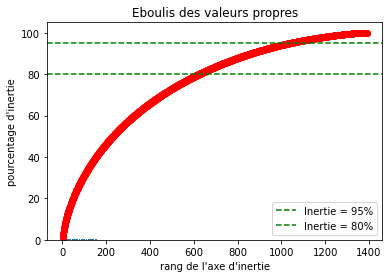

In [17]:
display_scree_plot(pca)

##### A lecture du graphique de l'éboulis des valeurs propres de notre jeu de données X, nous devons réduire le nombre des features à environ 950 features au lieu des 1 411 features obtenues après la première création des Bag-of-Words :

###### Variable explicative `question_lemtokcl`, extraction de features avec le modèle Bag-of-Words :
- utilisation du module TfidfVectorizer de la librairie Scikit-Learn pour combiner le CountVectorizer et TfidfTransformer afin minimiser la redondance de certains mots en appliquant le modèle du Bag-of-Words tout en créant des n-grams de type (1,2) en réglant max_features à 950 features.  

In [18]:
vectorizer = TfidfVectorizer(
    analyzer="word",
    max_df=0.75, #ignore terms that have a document frequency strictly higher than 75 %
    min_df=0.0058, #ignore terms that have a document frequency strictly lower than 0,58 %
    tokenizer=None, #neutralize tokenization of words because is already done in the 1st part
    preprocessor=' '.join,
    stop_words=None, #neutralize remove of stop_words because is already done in the 1st part
    lowercase=False, #neutralize conversion in lowercase because is already done in the 1st part
    ngram_range = (1,2), #extract unigrams and bigrams
    max_features = 950
)
X = vectorizer.fit_transform(df.question_lemtokcl) #tfidf

In [19]:
vectorizer.get_feature_names() #visualisation des Bags-of-Words

['able',
 'accept',
 'access',
 'account',
 'achieve',
 'across',
 'action',
 'active',
 'activity',
 'actual',
 'actually',
 'add',
 'add new',
 'address',
 'admin',
 'advance',
 'age',
 'ajax',
 'alert',
 'algorithm',
 'align',
 'alloc',
 'allow',
 'already',
 'also',
 'also try',
 'always',
 'amount',
 'android',
 'angular',
 'animation',
 'answer',
 'apache',
 'api',
 'app',
 'appear',
 'append',
 'application',
 'apply',
 'appreciate',
 'approach',
 'area',
 'args',
 'argument',
 'around',
 'array',
 'arraylist',
 'article',
 'ask',
 'asp',
 'aspdotnet',
 'aspx',
 'assembly',
 'asset',
 'assign',
 'assume',
 'async',
 'attempt',
 'attr',
 'attribute',
 'auth',
 'authentication',
 'author',
 'auto',
 'automatically',
 'available',
 'avoid',
 'await',
 'axis',
 'back',
 'background',
 'background color',
 'bad',
 'bar',
 'base',
 'bash',
 'basic',
 'basically',
 'batch',
 'become',
 'begin',
 'behavior',
 'big',
 'bin',
 'binary',
 'bind',
 'bit',
 'black',
 'blank',
 'block',
 'blo

In [20]:
print("Shape of X : {}".format(X.shape)) #print the shape of X

Shape of X : (35809, 950)


In [21]:
# Materialize the sparse data
data_dense = X.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  3.4771235105552702 %


###### Encodage des  valeurs de la variable cible `tag_tok` : 

In [22]:
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df.tag_tok)

In [23]:
print("Shape of y: {}".format(y.shape))

Shape of y: (35809, 8519)


###### Création des jeux de dataset `train` et `test` pour la variable explicative et la variable cible :

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3, random_state=42)
print("X_train shape : {}".format(X_train.shape))
print("X_test shape : {}".format(X_test.shape))
print("y_train shape : {}".format(y_train.shape))
print("y_test shape : {}".format(y_test.shape))

X_train shape : (25066, 950)
X_test shape : (10743, 950)
y_train shape : (25066, 8519)
y_test shape : (10743, 8519)


In [25]:
y_test

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [26]:
X_test

<10743x950 sparse matrix of type '<class 'numpy.float64'>'
	with 358382 stored elements in Compressed Sparse Row format>

### Méthode du LDA :
Dans le domaine du traitement automatique des langues, l’allocation de Dirichlet latente (de l’anglais Latent Dirichlet Allocation) ou LDA est un modèle génératif probabiliste permettant d’expliquer des ensembles d’observations, par le moyen de groupes non observés, eux-mêmes définis par des similarités de données.
Pour chaque mot `w` de chaque document `d`, on calcule deux quantités pour chaque thème `t` : 

`p(t|d)` : la probabilité que le document `d` soit assigné au thème `t`.
`p(w|d)` : la probabilité que le thème `t` dans le corpus soit assigné au mot `w`.
On choisit alors le nouveau thème t avec la probabilité `p(t|d)` X `p(w|d)`. Ceci correspond à la probabilité que le thème `t` génère le mot `w` dans le document `d`.

En répétant les étapes précédentes un grand nombre de fois, les assignations se stabilisent. On obtient le mélange de thème présent dans chaque document en comptant chaque représentation d’un thème (assigné aux mots du document). On obtient les mots associés à chaque thème en comptant les mots qui y sont associés dans le corpus.

In [31]:
dict={}
for i in [2,6,10,14]:    
    lda =  LDA(n_components = i).fit(X)
    perp=lda.perplexity(X)
    dict[i]=perp

In [32]:
dict

{2: 843.475772679589,
 6: 1155.561025454891,
 10: 1347.71894132418,
 14: 1532.3964163310482}

In [33]:
dict2={}
for i in [2,6,10,14]:    
    lda =  LDA(n_components = i).fit(X)
    scor=lda.score(X)
    dict2[i]=scor

In [34]:
dict2

{2: -1024422.94035151,
 6: -1075730.2022611343,
 10: -1100615.2209509145,
 14: -1119093.7874411915}

In [35]:
lda =  LDA(n_components = 10) #model construction with 10 topics wanted

In [36]:
lda.fit(X) #model compilation

LatentDirichletAllocation()

In [37]:
lda.perplexity(X) #calculate of the model's perplexity

1347.2571308582644

In [38]:
lda.score(X) #calculate of the model's score

-1098572.7688312598

In [39]:
pyLDAvis.sklearn.prepare(lda, X, vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.032569 -0.049729       1        1  14.327043
5      0.057249  0.097500       2        1  12.019907
2      0.100303 -0.105695       3        1  11.502392
6      0.029841  0.107517       4        1  11.079180
8     -0.089815 -0.037611       5        1   9.419280
4      0.063318 -0.061658       6        1   9.281460
1     -0.044044  0.115007       7        1   8.750437
3     -0.210326 -0.046113       8        1   8.140897
7      0.065625 -0.010905       9        1   8.042801
0     -0.004719 -0.008312      10        1   7.436604, topic_info=       Term         Freq        Total Category  logprob  loglift
245     div   533.000000   533.000000  Default  30.0000  30.0000
326    file  1133.000000  1133.000000  Default  29.0000  29.0000
831   table   573.000000   573.000000  Default  28.0000  28.0000
660  public   501.000000   501.000000  Default  27.0000  27.0000
432     int   499.000000   499.000000  Default  26.0000  26.0000
..      ...          ...          ...      ...      ...      ...
366     get    80.070412   883.656484  Topic10  -4.9530   0.1976
714  return    73.077968   640.827363  Topic10  -5.0443   0.4275
903   value    73.047365   855.137071  Topic10  -5.0448   0.1386
892     use    70.085774  1304.419979  Topic10  -5.0862  -0.3250
489    list    64.718193   582.109903  Topic10  -5.1658   0.4021

[555 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
8         1  0.090095  activity
8         3  0.027029  activity
8         4  0.018019  activity
8         5  0.009010  activity
8         6  0.009010  activity
...     ...       ...       ...
948       5  0.030572      year
948       6  0.007643      year
948       7  0.076429      year
948       9  0.022929      year
948      10  0.015286      year

[3416 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 6, 3, 7, 9, 5, 2, 4, 8, 1])

In [40]:
number_topics = 10
number_words = 10

lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(X)

print("Topics found via LDA:")
print_topics(lda, vectorizer, number_words)

Topics found via LDA:

Topic #0:
div image text width class button color height style html

Topic #1:
table date query sql select database column row mysql value

Topic #2:
page form user url use php html control button com

Topic #3:
use application server app run service thread window good way

Topic #4:
public class string object void new method int java private

Topic #5:
self cell model view product row excel end sheet name

Topic #6:
error function log json request response return console datum user

Topic #7:
string int array file value character number line return char

Topic #8:
list value datum array column plot dataframe number frame like

Topic #9:
file project use error run path version directory java build


#### Utilisation d'une méthode de "Fast LDA" :
- utilisation de LdaMulticore de la bibliothèque Gensim.

#### a. avec la variable `question_lemtokcl` sans preprocessing :

In [40]:
id2word = corpora.Dictionary(df.question_lemtokcl)

texts = df.question_lemtokcl
corpus = [id2word.doc2bow(text) for text in texts]

In [42]:
dict={}
for i in  np.arange(4,14,1) :
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=i, 
                                       random_state=42,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=df.question_lemtokcl, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    dict[i]=coherence_lda
    print('Coherence Score: ', coherence_lda)

Coherence Score:  0.4131412232981918
Coherence Score:  0.4299278642745322
Coherence Score:  0.4393413490153784
Coherence Score:  0.4839828721288657
Coherence Score:  0.47362765264410006
Coherence Score:  0.494320555497647
Coherence Score:  0.5113928423725029
Coherence Score:  0.49465499802906304
Coherence Score:  0.4894302055488728
Coherence Score:  0.48055449571209585


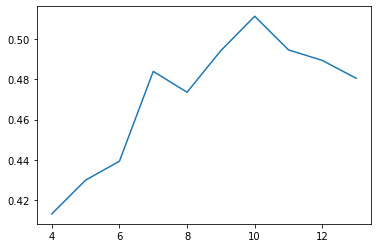

In [43]:
plt.plot(*zip(*sorted(dict.items())))
plt.show()

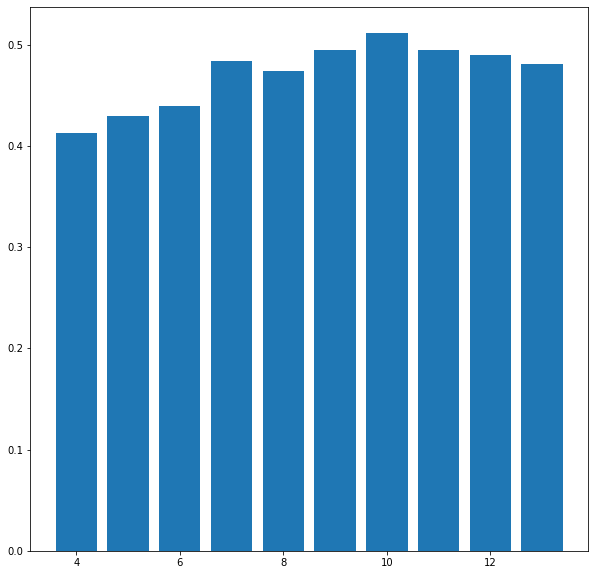

In [44]:
keys = dict.keys()
values = dict.values()

plt.figure(figsize=(10,10))
plt.bar(keys, values)
plt.show()

#### Modèle fastLDA avec 6 topics :

In [52]:
lda_model_6 = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=6, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [53]:
vis_6 = pyLDAvis.gensim_models.prepare(lda_model_6, corpus, id2word)

In [54]:
vis_6

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.004047 -0.052697       1        1  20.153675
1      0.142668 -0.105888       2        1  19.283481
4      0.128340  0.231296       3        1  17.476321
2     -0.134320  0.078737       4        1  16.560602
0      0.085342 -0.122733       5        1  16.483207
5     -0.217984 -0.028715       6        1  10.042714, topic_info=       Term          Freq         Total Category  logprob  loglift
38     file  21803.000000  21803.000000  Default  30.0000  30.0000
385     div  12698.000000  12698.000000  Default  29.0000  29.0000
31   string  16657.000000  16657.000000  Default  28.0000  28.0000
143     int  10624.000000  10624.000000  Default  27.0000  27.0000
84   public  10502.000000  10502.000000  Default  26.0000  26.0000
..      ...           ...           ...      ...      ...      ...
25     name   1680.476460  21129.118743   Topic6  -5.2673  -0.2333
619    test   1422.993911   9056.444013   Topic6  -5.4336   0.4476
39     find   1305.013152   9771.293280   Topic6  -5.5201   0.2851
280   build   1254.048592   4489.501673   Topic6  -5.5600   1.0230
216    work   1262.442107  16464.543310   Topic6  -5.5533  -0.2698

[512 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
924        1  0.969947    ability
924        3  0.015988    ability
924        4  0.010659    ability
13185      1  0.997437  accordion
352        1  0.991011  advantage
...      ...       ...        ...
4773       6  0.002035        xsl
7121       6  0.996859       yaml
9          1  0.125153       year
9          2  0.874901       year
2946       6  0.994092        yml

[1362 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 5, 3, 1, 6])

#### Modèle fastLDA avec 7 topics :

In [41]:
lda_model_7 = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=7, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [43]:
vis_7 = pyLDAvis.gensim_models.prepare(lda_model_7, corpus, id2word)

In [44]:
vis_7

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.028119  0.054422       1        1  22.387263
1      0.079013  0.149651       2        1  20.286631
4      0.106508  0.028125       3        1  16.975220
0      0.056310  0.130729       4        1  14.349786
2     -0.130642 -0.064329       5        1  12.388116
5     -0.249773 -0.049756       6        1   8.144042
3      0.166703 -0.248842       7        1   5.468942, topic_info=        Term          Freq         Total Category  logprob  loglift
38      file  22430.000000  22430.000000  Default  30.0000  30.0000
385      div  12822.000000  12822.000000  Default  29.0000  29.0000
143      int  11273.000000  11273.000000  Default  28.0000  28.0000
31    string  16676.000000  16676.000000  Default  27.0000  27.0000
3619    self   6874.000000   6874.000000  Default  26.0000  26.0000
...      ...           ...           ...      ...      ...      ...
771     true    831.669322   8167.413481   Topic7  -5.3629   0.6216
33       use    955.102437  36787.644825   Topic7  -5.2245  -0.7450
150      new    847.299100  17274.056452   Topic7  -5.3443  -0.1088
231    class    755.032673  21342.524648   Topic7  -5.4596  -0.4356
232     code    745.461767  20516.628519   Topic7  -5.4723  -0.4089

[570 rows x 6 columns], token_table=       Topic      Freq            Term
term                                  
22037      5  0.993049  activitythread
0          2  0.977099             age
0          4  0.002329             age
0          7  0.019798             age
2764       1  0.021977            ajax
...      ...       ...             ...
7121       7  0.997221            yaml
9          1  0.097981            year
9          2  0.878226            year
9          7  0.023443            year
2946       6  0.996472             yml

[1607 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 2, 5, 1, 3, 6, 4])

#### Modèle fastLDA avec 8 topics :

In [49]:
lda_model_8 = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=8, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [50]:
vis_8 = pyLDAvis.gensim_models.prepare(lda_model_8, corpus, id2word)

In [51]:
vis_8

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.020875  0.001448       1        1  21.738629
1     -0.144937 -0.008084       2        1  17.276156
4     -0.064513 -0.225745       3        1  16.521528
0     -0.080045 -0.064129       4        1  13.712303
2      0.136772 -0.052739       5        1  12.217515
7      0.010746  0.025267       6        1   9.189039
5      0.304327  0.071642       7        1   5.073639
3     -0.141473  0.252339       8        1   4.271191, topic_info=        Term          Freq         Total Category  logprob  loglift
38      file  22649.000000  22649.000000  Default  30.0000  30.0000
385      div  12977.000000  12977.000000  Default  29.0000  29.0000
355     date   7283.000000   7283.000000  Default  28.0000  28.0000
143      int  11402.000000  11402.000000  Default  27.0000  27.0000
3619    self   6432.000000   6432.000000  Default  26.0000  26.0000
...      ...           ...           ...      ...      ...      ...
393   create    702.724759  12266.913420   Topic8  -5.2842   0.2936
21       get    710.646912  23837.034128   Topic8  -5.2730  -0.3595
513    datum    674.649553  18496.331047   Topic8  -5.3249  -0.1579
630   update    619.389747   5728.913902   Topic8  -5.4104   0.9287
205   server    622.830861   7595.856720   Topic8  -5.4049   0.6522

[647 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
19699      1  0.990287        ack
352        1  0.988092  advantage
352        8  0.006501  advantage
0          8  0.998498        age
712        1  0.992776        air
...      ...       ...        ...
1137       8  0.997240       yyyy
3957       2  0.024445        zip
3957       5  0.036667        zip
3957       6  0.920749        zip
3957       7  0.016296        zip

[1927 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 2, 5, 1, 3, 8, 6, 4])

#### Modèle fastLDA avec 10 topics :

In [45]:
lda_model_10 = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [47]:
vis_10 = pyLDAvis.gensim_models.prepare(lda_model_10, corpus, id2word)

In [48]:
vis_10

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.109010  0.033541       1        1  18.076554
1     -0.096597 -0.051146       2        1  13.844841
4     -0.028221 -0.074032       3        1  13.836909
0     -0.062484  0.000793       4        1  13.317848
2     -0.017762  0.077240       5        1  12.906062
8     -0.065708  0.102846       6        1   8.768042
9     -0.097773  0.040464       7        1   8.194194
7     -0.045790  0.038701       8        1   5.691786
3      0.139384 -0.307452       9        1   3.170236
5      0.383963  0.139045      10        1   2.193527, topic_info=            Term          Freq         Total Category  logprob  loglift
38          file  23628.000000  23628.000000  Default  30.0000  30.0000
3619        self   6874.000000   6874.000000  Default  29.0000  29.0000
385          div  13219.000000  13219.000000  Default  28.0000  28.0000
31        string  18640.000000  18640.000000  Default  27.0000  27.0000
84        public  11698.000000  11698.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
4696     channel    395.888899    875.103199  Topic10  -5.1916   3.0265
3733       super    313.103878   1124.087468  Topic10  -5.4262   2.5415
3086  controller    362.347174   2262.662983  Topic10  -5.2802   1.9880
162       return    413.274521  16948.782157  Topic10  -5.1486   0.1058
1251      import    335.842359   8620.697545  Topic10  -5.3561   0.5744

[766 rows x 6 columns], token_table=       Topic      Freq  Term
term                        
28281      2  0.997330   acc
21693      1  0.992904   adb
100        1  0.219726   add
100        2  0.189457   add
100        3  0.163963   add
...      ...       ...   ...
1137       8  0.002511  yyyy
1137       9  0.996986  yyyy
3957       5  0.005806   zip
3957       6  0.015483   zip
3957       8  0.977365   zip

[2465 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 2, 5, 1, 3, 9, 10, 8, 4, 6])

### Méthodes Supervisées :

In [27]:
sgd = SGDClassifier()
lr = LogisticRegression()
mn = MultinomialNB()
per = Perceptron()
gbc = GradientBoostingClassifier()
rfc = RandomForestClassifier()
svc = LinearSVC()
cmp = ComplementNB()

#### Méthode One VS Rest Classifier :

##### Modèle SGD Classifier avec la méthode One VS Rest Classifier :

In [52]:
start0 = time.process_time()

In [53]:
clfsgd = OneVsRestClassifier(sgd)
clfsgd.fit(X_train, y_train)
y_pred_sgd = clfsgd.predict(X_test)   

In [54]:
end0 = time.process_time()
time0 = end0 - start0
print('Run Time :', time0)

Run Time : 127.84375


In [55]:
sgd_1vsrest_accuracy = metrics.accuracy_score(y_test, y_pred_sgd)
sgd_1vsrest_f1_score = metrics.f1_score(y_pred_sgd, y_test, average='weighted')
sgd_1vsrest_jaccards = metrics.jaccard_score(y_test, y_pred_sgd, average='weighted')
sgd_1vsrest_recallsc = metrics.recall_score(y_test, y_pred_sgd, average='weighted')
sgd_1vsrest_precison = metrics.precision_score(y_test, y_pred_sgd, average='weighted')

In [56]:
metrics_sgd_1vsrclass = metric_model('SGDClass_1VsRestClass', y_test, y_pred_sgd, time0)
metrics_sgd_1vsrclass.style.set_properties(**{'background-color': 'lemonchiffon','color': 'green'})

,Accuracy,F1,Jaccard,Recall,Precision,Run Time
SGDClass_1VsRestClass,0.024295,0.580079,0.146756,0.158874,0.340688,127.843750


##### Modèle Logistic Régression avec la méthode One VS Rest Classifier :

In [57]:
start1 = time.process_time()

In [58]:
clflr = OneVsRestClassifier(lr)
clflr.fit(X_train, y_train)
y_pred_lr = clflr.predict(X_test) 

In [59]:
end1 = time.process_time()
time1 = end1 - start1
print('Run Time :', time1)

Run Time : 387.828125


In [60]:
lr_1vsrest_accuracy = metrics.accuracy_score(y_test, y_pred_lr)
lr_1vsrest_f1_score = metrics.f1_score(y_pred_lr, y_test, average='weighted')
lr_1vsrest_jaccards = metrics.jaccard_score(y_test, y_pred_lr, average='weighted')
lr_1vsrest_recallsc = metrics.recall_score(y_test, y_pred_lr, average='weighted')
lr_1vsrest_precison = metrics.precision_score(y_test, y_pred_lr, average='weighted')

In [61]:
metrics_lr_1vsrclass = metric_model('LogisticReg_1VsRestClass', y_test, y_pred_lr, time1)
metrics_lr_1vsrclass.style.set_properties(**{'background-color': 'lemonchiffon','color': 'green'})

,Accuracy,F1,Jaccard,Recall,Precision,Run Time
LogisticReg_1VsRestClass,0.026994,0.519371,0.151626,0.163532,0.410137,387.828125


##### Modèle  Multinomial NB avec la méthode One VS Rest Classifier :

In [62]:
start2 = time.process_time()

In [63]:
clfmn = OneVsRestClassifier(mn)
clfmn.fit(X_train, y_train)
y_pred_mn = clfmn.predict(X_test) 

In [64]:
end2 = time.process_time()
time2 = end2 - start2
print('Run Time :', time2)

Run Time : 57.6875


In [65]:
mn_1vsrest_accuracy = metrics.accuracy_score(y_test, y_pred_mn)
mn_1vsrest_f1_score = metrics.f1_score(y_pred_mn, y_test, average='weighted')
mn_1vsrest_jaccards = metrics.jaccard_score(y_test, y_pred_mn, average='weighted')
mn_1vsrest_recallsc = metrics.recall_score(y_test, y_pred_mn, average='weighted')
mn_1vsrest_precison = metrics.precision_score(y_test, y_pred_mn, average='weighted')

In [66]:
metrics_mn_1vsrclass = metric_model('MultinomialNB _1VsRestClass', y_test, y_pred_mn, time2)
metrics_mn_1vsrclass.style.set_properties(**{'background-color': 'lemonchiffon','color': 'green'})

,Accuracy,F1,Jaccard,Recall,Precision,Run Time
MultinomialNB _1VsRestClass,0.008657,0.380516,0.057158,0.062486,0.294668,57.687500


##### Modèle  Perceptron avec la méthode One VS Rest Classifier :

In [67]:
start3 = time.process_time()

In [68]:
clfper = OneVsRestClassifier(per)
clfper.fit(X_train, y_train)
y_pred_per = clfper.predict(X_test) 

In [69]:
end3 = time.process_time()
time3 = end3 - start3
print('Run Time :', time3)

Run Time : 140.234375


In [70]:
per_1vsrest_accuracy = metrics.accuracy_score(y_test, y_pred_per)
per_1vsrest_f1_score = metrics.f1_score(y_pred_per, y_test, average='weighted')
per_1vsrest_jaccards = metrics.jaccard_score(y_test, y_pred_per, average='weighted')
per_1vsrest_recallsc = metrics.recall_score(y_test, y_pred_per, average='weighted')
per_1vsrest_precison = metrics.precision_score(y_test, y_pred_per, average='weighted')

In [71]:
metrics_per_1vsrclass = metric_model('Perceptron_1VsRestClass', y_test, y_pred_per, time3)
metrics_per_1vsrclass.style.set_properties(**{'background-color': 'lemonchiffon','color': 'green'})

,Accuracy,F1,Jaccard,Recall,Precision,Run Time
Perceptron_1VsRestClass,0.012752,0.222526,0.177246,0.270100,0.278960,140.234375


##### Modèle  Linear SVC avec la méthode One VS Rest Classifier :

In [72]:
start4 = time.process_time()

In [73]:
clfsvc = OneVsRestClassifier(svc)
clfsvc.fit(X_train, y_train)
y_pred_svc = clfsvc.predict(X_test)

In [74]:
end4 = time.process_time()
time4 = end4 - start4
print('Run Time :', time4)

Run Time : 219.703125


In [75]:
svc_1vsrest_accuracy = metrics.accuracy_score(y_test, y_pred_svc)
svc_1vsrest_f1_score = metrics.f1_score(y_pred_svc, y_test, average='weighted')
svc_1vsrest_jaccards = metrics.jaccard_score(y_test, y_pred_svc, average='weighted')
svc_1vsrest_recallsc = metrics.recall_score(y_test, y_pred_svc, average='weighted')
svc_1vsrest_precison = metrics.precision_score(y_test, y_pred_svc, average='weighted')

In [76]:
metrics_svc_1vsrclass = metric_model('LinearSVC_1VsRestClass', y_test, y_pred_svc, time4)
metrics_svc_1vsrclass.style.set_properties(**{'background-color': 'lemonchiffon','color': 'green'})

,Accuracy,F1,Jaccard,Recall,Precision,Run Time
LinearSVC_1VsRestClass,0.039281,0.554768,0.198556,0.221187,0.447989,219.703125


#### Confrontation des métriques des modèles avec la méthode One VS Rest Classifier :

In [77]:
 frames = [metrics_sgd_1vsrclass, metrics_lr_1vsrclass, metrics_mn_1vsrclass, metrics_per_1vsrclass, metrics_svc_1vsrclass]
tab_metrics_1vsrclass = pd.concat(frames)
tab_metrics_1vsrclass.style.set_properties(**{'background-color': 'lemonchiffon','color': 'green'}).highlight_min(axis=0, color='aliceblue').highlight_max(axis=0, color='lavenderblush')

,Accuracy,F1,Jaccard,Recall,Precision,Run Time
SGDClass_1VsRestClass,0.024295,0.580079,0.146756,0.158874,0.340688,127.843750
LogisticReg_1VsRestClass,0.026994,0.519371,0.151626,0.163532,0.410137,387.828125
MultinomialNB _1VsRestClass,0.008657,0.380516,0.057158,0.062486,0.294668,57.687500
Perceptron_1VsRestClass,0.012752,0.222526,0.177246,0.270100,0.278960,140.234375
LinearSVC_1VsRestClass,0.039281,0.554768,0.198556,0.221187,0.447989,219.703125


#### Sélection du meilleur modèle et optimisation par Grid Search du meilleur modèle :

In [106]:
svc.get_params()

{'estimator__C': 1.0,
 'estimator__class_weight': None,
 'estimator__dual': True,
 'estimator__fit_intercept': True,
 'estimator__intercept_scaling': 1,
 'estimator__loss': 'squared_hinge',
 'estimator__max_iter': 1000,
 'estimator__multi_class': 'ovr',
 'estimator__penalty': 'l2',
 'estimator__random_state': None,
 'estimator__tol': 0.0001,
 'estimator__verbose': 0,
 'estimator': LinearSVC(),
 'n_jobs': None}

In [77]:
#param_grid = {'estimator__C':[0.1,0.5,1,1.5,2,10,50]}

In [114]:
param_grid = {'estimator__C':[1,2,4,8]}#, 'estimator__penalty':[1, 6, 12], 'estimator__max_iter':[500, 1000]}

In [115]:
svc = OneVsRestClassifier(LinearSVC())
CV_svc = model_selection.GridSearchCV(estimator=svc, param_grid=param_grid, cv= 3, verbose=10,
                                      scoring=metrics.precision_score)

In [116]:
CV_svc.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3; 1/4] START estimator__C=1..............................................
[CV 1/3; 1/4] END ............................estimator__C=1; total time= 1.7min
[CV 2/3; 1/4] START estimator__C=1..............................................
[CV 2/3; 1/4] END ............................estimator__C=1; total time= 1.7min
[CV 3/3; 1/4] START estimator__C=1..............................................
[CV 3/3; 1/4] END ............................estimator__C=1; total time= 1.7min
[CV 1/3; 2/4] START estimator__C=2..............................................
[CV 1/3; 2/4] END ............................estimator__C=2; total time= 1.8min
[CV 2/3; 2/4] START estimator__C=2..............................................
[CV 2/3; 2/4] END ............................estimator__C=2; total time= 1.7min
[CV 3/3; 2/4] START estimator__C=2..............................................
[CV 3/3; 2/4] END ............................est

GridSearchCV(cv=3, estimator=OneVsRestClassifier(estimator=LinearSVC()),
             param_grid={'estimator__C': [1, 2, 4, 8]},
             scoring=<function precision_score at 0x000001DE80A46AF0>,
             verbose=10)

In [117]:
CV_svc.best_params_

{'estimator__C': 1}

In [118]:
best_model = CV_svc.best_estimator_

In [119]:
startbest = time.process_time()

In [120]:
y_pred_svc_bestmodel = best_model.predict(X_test)

In [121]:
endbest = time.process_time()
timebest = endbest - startbest
print('Run Time :', timebest)

Run Time : 3.6875


In [122]:
best_model.score(X,y)

0.07682426205702476

In [123]:
best_model.decision_function(X)

array([[-1.2093815 , -1.21154628, -1.23664925, ..., -1.17377626,
        -1.2418049 , -1.34827764],
       [-1.31612034, -1.17482826, -1.28238113, ..., -1.16425969,
        -1.15397032, -1.22166079],
       [-1.32222016, -1.20977507, -1.18373869, ..., -1.2063258 ,
        -1.31281915, -1.46396078],
       ...,
       [-1.32028164, -1.23615263, -1.22145302, ..., -1.17480929,
        -1.3001923 , -1.12793875],
       [-1.12041398, -1.16953886, -1.19961526, ..., -1.19741267,
        -1.25296636, -1.41242769],
       [-1.29801602, -1.21349384, -1.2510308 , ..., -1.2064911 ,
        -1.12668485, -1.07487685]])

In [142]:
metrics_svc_bestmodel = metric_model('LinearSVC_1VsRestClass_opt', y_test, y_pred_svc_bestmodel, timebest)
metrics_svc_bestmodel.style.set_properties(**{'background-color': 'lemonchiffon','color': 'green'})

,Accuracy,F1,Jaccard,Recall,Precision,Run Time
LinearSVC_1VsRestClass_opt,0.039281,0.554768,0.198556,0.221187,0.447989,3.687500


In [ ]:
#param_grid1 = {'estimator__C':[1,2,4,8], 'estimator__max_iter':[500, 1000]}

In [28]:
param_grid1 = {'estimator__C':[1,2], 'estimator__max_iter':[100, 500]}

In [29]:
svc = OneVsRestClassifier(LinearSVC())
CV_svc1 = model_selection.GridSearchCV(estimator=svc, param_grid=param_grid1, cv= 3, verbose=10,
                                      scoring=metrics.precision_score)

In [30]:
CV_svc1.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3; 1/4] START estimator__C=1, estimator__max_iter=100.....................
[CV 1/3; 1/4] END estimator__C=1, estimator__max_iter=100;, score=nan total time= 1.7min
[CV 2/3; 1/4] START estimator__C=1, estimator__max_iter=100.....................
[CV 2/3; 1/4] END estimator__C=1, estimator__max_iter=100;, score=nan total time= 1.8min
[CV 3/3; 1/4] START estimator__C=1, estimator__max_iter=100.....................
[CV 3/3; 1/4] END estimator__C=1, estimator__max_iter=100;, score=nan total time= 1.9min
[CV 1/3; 2/4] START estimator__C=1, estimator__max_iter=500.....................
[CV 1/3; 2/4] END estimator__C=1, estimator__max_iter=500;, score=nan total time= 1.8min
[CV 2/3; 2/4] START estimator__C=1, estimator__max_iter=500.....................
[CV 2/3; 2/4] END estimator__C=1, estimator__max_iter=500;, score=nan total time= 1.9min
[CV 3/3; 2/4] START estimator__C=1, estimator__max_iter=500.....................
[CV 3/3; 

GridSearchCV(cv=3, estimator=OneVsRestClassifier(estimator=LinearSVC()),
             param_grid={'estimator__C': [1, 2],
                         'estimator__max_iter': [100, 500]},
             scoring=<function precision_score at 0x000001F56B376820>,
             verbose=10)

In [31]:
CV_svc1.best_params_

{'estimator__C': 1, 'estimator__max_iter': 100}

In [32]:
best_model1 = CV_svc1.best_estimator_

In [33]:
startbest1 = time.process_time()

In [34]:
y_pred_svc_bestmodel1 = best_model1.predict(X_test)

In [35]:
endbest1 = time.process_time()
timebest1 = endbest1 - startbest1
print('Run Time :', timebest1)

Run Time : 3.8125


In [36]:
best_model1.score(X,y)

0.07682426205702476

In [37]:
best_model1.decision_function(X)

array([[-1.20938754, -1.21155055, -1.23665018, ..., -1.17375996,
        -1.24180688, -1.34828132],
       [-1.31612488, -1.17483333, -1.2823828 , ..., -1.16424308,
        -1.15397642, -1.22166388],
       [-1.32222661, -1.20977696, -1.18374115, ..., -1.20630973,
        -1.31282227, -1.46396201],
       ...,
       [-1.32028534, -1.23615612, -1.22145889, ..., -1.17479254,
        -1.30019592, -1.12794274],
       [-1.12042272, -1.169542  , -1.19961595, ..., -1.19739678,
        -1.25296938, -1.41243265],
       [-1.29801943, -1.21349877, -1.25103369, ..., -1.20647633,
        -1.12668675, -1.07487875]])

In [135]:
metrics_svc_bestmodel1 = metric_model('LinearSVC_1VsRestClass', y_test, y_pred_svc_bestmodel1, timebest1)
metrics_svc_bestmodel1.style.set_properties(**{'background-color': 'lemonchiffon','color': 'green'})

,Accuracy,F1,Jaccard,Recall,Precision,Run Time
LinearSVC_1VsRestClass,0.039281,0.554768,0.198556,0.221187,0.447989,3.765625


#### Export du meilleur modèle optimisé et des préprocessings :

In [136]:
joblib.dump(best_model,'best_model.pkl')  

['best_model.pkl']

In [137]:
joblib.dump(vectorizer,'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

In [138]:
joblib.dump(mlb,'multilabel_binarizer.pkl')

['multilabel_binarizer.pkl']

#### Méthode Classifier Chain:

##### Modèle  Multinomial NB avec la méthode Classifier Chain :

In [89]:
"""
chnmn = ClassifierChain(mn, order='random', random_state=0, cv = 100)
chnmn.fit(X_train, y_train)
y_pred_chnmn = chnmn.predict(X_test)
"""

"\nchnmn = ClassifierChain(mn, order='random', random_state=0, cv = 100)\nchnmn.fit(X_train, y_train)\ny_pred_chnmn = chnmn.predict(X_test)\n"

In [120]:
"""
mn_chn_accuracy = metrics.accuracy_score(y_test, y_pred_chnmn)
mn_chn_f1_score = metrics.f1_score(y_pred_chnmn, y_test, average='weighted')
mn_chn_jaccards = metrics.jaccard_score(y_test, y_pred_chnmn, average='weighted')
mn_chn_recallsc = metrics.recall_score(y_test, y_pred_chnmn, average='weighted')
mn_chn_precison = metrics.precision_score(y_test, y_pred_chnmn, average='weighted')
metrics_mn_chn = metric_model('MultinomialNB_ClassChain', y_test, y_pred_chnmn)
metrics_mn_chn.style.set_properties(**{'background-color': 'lemonchiffon','color': 'green'})
"""

"\nmn_chn_accuracy = metrics.accuracy_score(y_test, y_pred_chnmn)\nmn_chn_f1_score = metrics.f1_score(y_pred_chnmn, y_test, average='weighted')\nmn_chn_jaccards = metrics.jaccard_score(y_test, y_pred_chnmn, average='weighted')\nmn_chn_recallsc = metrics.recall_score(y_test, y_pred_chnmn, average='weighted')\nmn_chn_precison = metrics.precision_score(y_test, y_pred_chnmn, average='weighted')\nmetrics_mn_chn = metric_model('MultinomialNB_ClassChain', y_test, y_pred_chnmn)\nmetrics_mn_chn.style.set_properties(**{'background-color': 'lemonchiffon','color': 'green'})\n"

##### Modèle  Complement NB avec la méthode Classifier Chain :

In [121]:
"""
chncmp = ClassifierChain(cmp, order='random', random_state=0)
chncmp.fit(X_train, y_train)
y_pred_chncmp = chncmp.predict(X_test)
"""

"\nchncmp = ClassifierChain(cmp, order='random', random_state=0)\nchncmp.fit(X_train, y_train)\ny_pred_chncmp = chncmp.predict(X_test)\n"

In [122]:
"""
cmp_chn_accuracy = metrics.accuracy_score(y_test, y_pred_chncmp)
cmp_chn_f1_score = metrics.f1_score(y_pred_chncmp, y_test, average='weighted')
cmp_chn_jaccards = metrics.jaccard_score(y_test, y_pred_chncmp, average='weighted')
cmp_chn_recallsc = metrics.recall_score(y_test, y_pred_chncmp, average='weighted')
cmp_chn_precison = metrics.precision_score(y_test, y_pred_chncmp, average='weighted')
metrics_cmp_chn = metric_model('ComplementNB_ClassChain', y_test, y_pred_chncmp)
metrics_cmp_chn.style.set_properties(**{'background-color': 'lemonchiffon','color': 'green'})
"""

"\ncmp_chn_accuracy = metrics.accuracy_score(y_test, y_pred_chncmp)\ncmp_chn_f1_score = metrics.f1_score(y_pred_chncmp, y_test, average='weighted')\ncmp_chn_jaccards = metrics.jaccard_score(y_test, y_pred_chncmp, average='weighted')\ncmp_chn_recallsc = metrics.recall_score(y_test, y_pred_chncmp, average='weighted')\ncmp_chn_precison = metrics.precision_score(y_test, y_pred_chncmp, average='weighted')\nmetrics_cmp_chn = metric_model('ComplementNB_ClassChain', y_test, y_pred_chncmp)\nmetrics_cmp_chn.style.set_properties(**{'background-color': 'lemonchiffon','color': 'green'})\n"

##### Modèle  Random Forest Classifier avec la méthode Classifier Chain :

In [123]:
"""
chnrfc = ClassifierChain(rfc, order='random', random_state=0)
chnrfc.fit(X_train, y_train)
y_pred_chnrfc = chnrfc.predict(X_test)
"""

"\nchnrfc = ClassifierChain(rfc, order='random', random_state=0)\nchnrfc.fit(X_train, y_train)\ny_pred_chnrfc = chnrfc.predict(X_test)\n"

In [124]:
"""
rfc_chn_accuracy = metrics.accuracy_score(y_test, y_pred_chnrfc)
rfc_chn_f1_score = metrics.f1_score(y_pred_chnrfc, y_test, average='weighted')
rfc_chn_jaccards = metrics.jaccard_score(y_test, y_pred_chnrfc, average='weighted')
rfc_chn_recallsc = metrics.recall_score(y_test, y_pred_chnrfc, average='weighted')
rfc_chn_precison = metrics.precision_score(y_test, y_pred_chnrfc, average='weighted')
metrics_rfc_chn = metric_model('RandomForest_ClassChain', y_test, y_pred_chnrfc)
metrics_rfc_chn.style.set_properties(**{'background-color': 'lemonchiffon','color': 'green'})
"""

"\nrfc_chn_accuracy = metrics.accuracy_score(y_test, y_pred_chnrfc)\nrfc_chn_f1_score = metrics.f1_score(y_pred_chnrfc, y_test, average='weighted')\nrfc_chn_jaccards = metrics.jaccard_score(y_test, y_pred_chnrfc, average='weighted')\nrfc_chn_recallsc = metrics.recall_score(y_test, y_pred_chnrfc, average='weighted')\nrfc_chn_precison = metrics.precision_score(y_test, y_pred_chnrfc, average='weighted')\nmetrics_rfc_chn = metric_model('RandomForest_ClassChain', y_test, y_pred_chnrfc)\nmetrics_rfc_chn.style.set_properties(**{'background-color': 'lemonchiffon','color': 'green'})\n"

In [125]:
end_dr1 = time.process_time()
time_dr1 = end_dr1 - start_dr1
print('Run Time :', time_dr1)

Run Time : 9761.515625
